In [1]:
import shap
import pickle
import optuna
import numpy as np
import lightgbm as lgb
import optuna.integration
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

# File with the flux tube geometries (features):
in_filename = "20240601-01-assembleFluxTubeMatrix_normalizeMeanStdIndependentOfZ_withAndWithoutCvdrift_nz97_withCvdrift.pkl"
# File with the GX heat flux
out_filename = "20240601-01-103_gx_nfp4_production_gx_results.pkl"

with open(in_filename, "rb") as f:
    in_data = pickle.load(f)

with open(out_filename, "rb") as f:
    out_data = pickle.load(f)

X = in_data["matrix"]
heat_flux_averages = out_data["Q_avgs"]

In [2]:
in_data.keys()

dict_keys(['tube_files', 'nl', 'z_functions', 'scalars', 'n_features', 'n_quantities', 'n_tubes', 'matrix', 'means', 'standard_deviations'])

In [3]:
in_data["matrix"]

array([[ 0.02278433,  0.79329694,  0.47829241, ..., -0.85963928,
        -0.8744202 , -0.80227028],
       [ 1.87583922,  1.81435098,  0.96975006, ...,  0.95706323,
         0.87230722,  0.27335504],
       [ 0.43586769,  1.80462561,  1.59276536, ..., -0.4965529 ,
        -0.77648957, -0.89956508],
       ...,
       [ 0.13053565, -0.7773523 , -0.59668751, ..., -0.37490712,
        -0.62196128, -0.69224254],
       [-1.35382024, -0.85957927, -0.1629058 , ...,  2.14119896,
         2.06968399,  1.78776422],
       [-0.31146954, -0.13072943, -0.79157277, ...,  1.37519525,
         1.23457818,  0.48518993]])

In [4]:
out_data["Q_avgs"]

array([ 9.75939  ,  9.549901 , 11.110395 , ..., 16.632994 ,  7.2723794,
       16.234438 ], dtype=float32)

In [5]:
features = in_data["matrix"]
target = np.log(out_data["Q_avgs"])

train_x, valid_x, train_y, valid_y = train_test_split(features, target, test_size=0.2, random_state=1337)

In [6]:
# Define the objective function
def objective(trial):

    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

    param = {
        'objective': trial.suggest_categorical("objective", ["regression_l2", "regression_l1"]),
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "rf", "dart"]),
        'linear_tree': trial.suggest_categorical("linear_tree", [True, False]),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'num_iterations': trial.suggest_int('num_iterations', 10, 1000)
    }

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'rmse')

    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback])

    preds = gbm.predict(valid_x)
    r2 = r2_score(valid_y, preds)
    
    return -r2

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=500)

# Display the best hyperparameters
print('Best hyperparameters: ', study.best_params)

[I 2024-06-12 11:12:58,160] A new study created in memory with name: no-name-e61aa268-fb96-4731-bd05-7df823585296
/Users/goncaloabreu/repos/fusionchallenge/virtual/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2024-06-12 11:13:10,975] Trial 0 finished with value: -0.04248473347012749 and parameters: {'objective': 'regression_l2', 'boosting_type': 'gbdt', 'linear_tree': True, 'lambda_l1': 2.491117827245083, 'lambda_l2': 0.005816290492831879, 'num_leaves': 208, 'feature_fraction': 0.9215603838490352, 'bagging_fraction': 0.7798777753804567, 'bagging_freq': 4, 'min_child_samples': 66, 'learning_rate': 6.687728237818903e-05, 'max_depth': 32, 'min_split_gain': 0.18295954514053436, 'subsample': 0.4130624660233194, 'colsample_bytree': 0.2702336182752555, 'num_iterations': 742}. Best is trial 0 with value: -0.04248473347012749.
/U

Best hyperparameters:  {'objective': 'regression_l2', 'boosting_type': 'dart', 'linear_tree': True, 'lambda_l1': 0.031619903317949206, 'lambda_l2': 0.0065564322940762565, 'num_leaves': 38, 'feature_fraction': 0.6658394975888934, 'bagging_fraction': 0.95550858080524, 'bagging_freq': 9, 'min_child_samples': 50, 'learning_rate': 0.18256694843845048, 'max_depth': 36, 'min_split_gain': 0.0001592779435763735, 'subsample': 0.3004801969065329, 'colsample_bytree': 0.3164481879855481, 'num_iterations': 470}


In [10]:
study.best_params

{'objective': 'regression_l2',
 'boosting_type': 'dart',
 'linear_tree': True,
 'lambda_l1': 0.031619903317949206,
 'lambda_l2': 0.0065564322940762565,
 'num_leaves': 38,
 'feature_fraction': 0.6658394975888934,
 'bagging_fraction': 0.95550858080524,
 'bagging_freq': 9,
 'min_child_samples': 50,
 'learning_rate': 0.18256694843845048,
 'max_depth': 36,
 'min_split_gain': 0.0001592779435763735,
 'subsample': 0.3004801969065329,
 'colsample_bytree': 0.3164481879855481,
 'num_iterations': 470}

In [7]:
dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)    

gbm = lgb.train(study.best_params, dtrain, valid_sets=[dvalid])

[LightGBM] [Warning] bagging_fraction is set=0.95550858080524, subsample=0.3004801969065329 will be ignored. Current value: bagging_fraction=0.95550858080524
[LightGBM] [Warning] feature_fraction is set=0.6658394975888934, colsample_bytree=0.3164481879855481 will be ignored. Current value: feature_fraction=0.6658394975888934
[LightGBM] [Warning] bagging_fraction is set=0.95550858080524, subsample=0.3004801969065329 will be ignored. Current value: bagging_fraction=0.95550858080524
[LightGBM] [Warning] feature_fraction is set=0.6658394975888934, colsample_bytree=0.3164481879855481 will be ignored. Current value: feature_fraction=0.6658394975888934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173145
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 679
[LightGBM] [Warning] bagging_fraction is set=0.95550858

In [8]:
preds = gbm.predict(valid_x)
rmse = root_mean_squared_error(valid_y, preds)
rmse

0.3017665687195679

Text(0.5, 1.0, 'Nonlinear GX turbulence calculations, linear regression using cvdrift: $R^2$ = 0.754')

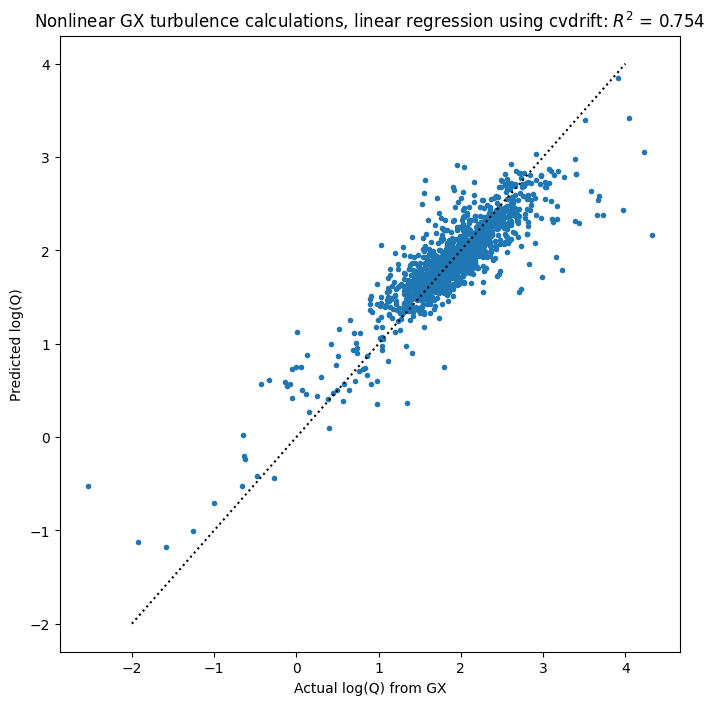

In [9]:
R2 = r2_score(valid_y, preds)

plt.figure(figsize=(8, 8))
plt.plot(valid_y, preds, '.')
plt.plot([-2, 4], [-2, 4], ':k')
plt.xlabel("Actual log(Q) from GX")
plt.ylabel("Predicted log(Q)")
plt.title(f"Nonlinear GX turbulence calculations, linear regression using cvdrift: $R^2$ = {R2:.3}")

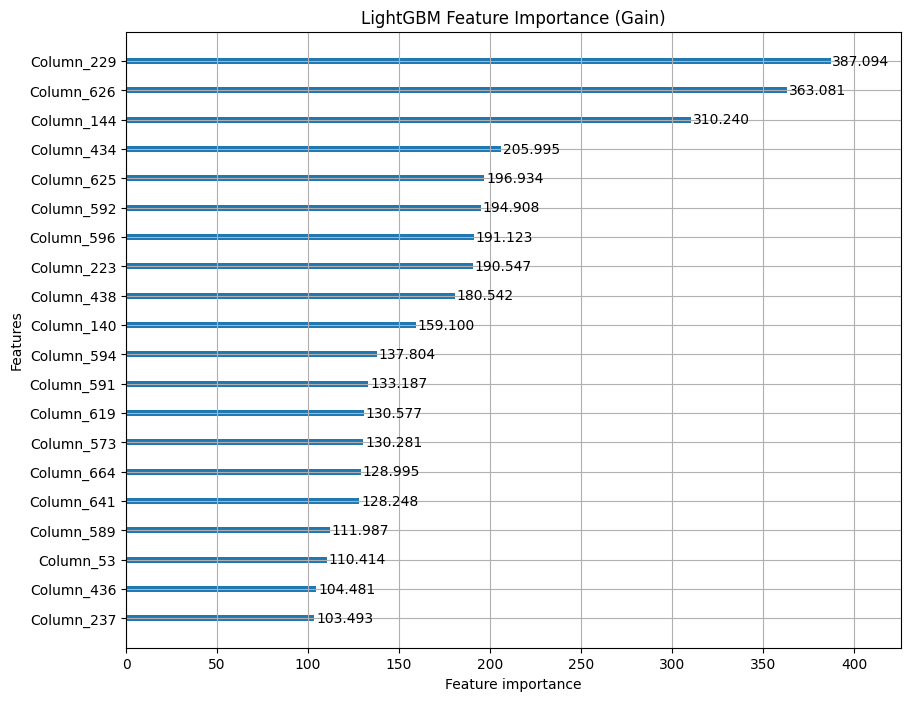

In [12]:
# Define the number of top features to plot
top_n_features = 20  # Change this value to display more or fewer features

# Plot feature importance using Gain
ax = lgb.plot_importance(gbm, importance_type="gain", max_num_features=top_n_features, figsize=(10, 8))
ax.set_title("LightGBM Feature Importance (Gain)")
plt.show()

In [13]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer(features)

[LightGBM] [Fatal] Predicting SHAP feature contributions is not implemented for linear trees.


LightGBMError: Predicting SHAP feature contributions is not implemented for linear trees.